# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import skimage
from skimage import transform
import datetime
import os
import pandas as pd
import random
from skimage.filters import gaussian
from skimage.util import random_noise
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

%pip install imgaug
import imgaug as ia
from imgaug import augmenters as iaa

Note: you may need to restart the kernel to use updated packages.


We set the random seed so that the results don't vary drastically.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
import random as rn
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)
%matplotlib inline


# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
batch_size = 10
base_path = 'Project_data/'

In [5]:
train_doc = np.random.permutation(open(base_path+'train.csv').readlines())
val_doc = np.random.permutation(open(base_path + 'val.csv').readlines())

# Explore Data

In [6]:
def read_data(source):
    df = pd.read_csv(source, header=None)
    df[['folder', 'name', 'class']] = df[0].str.split(';', expand=True)
    return df

In [7]:
def explore_data(source):
    df = read_data(source)
    print(df['class'].value_counts())

In [8]:
# Train data
explore_data(base_path+'train.csv')

3    137
1    137
0    136
2    130
4    123
Name: class, dtype: int64


In [9]:
# Val data
explore_data(base_path+'val.csv')

1    23
2    22
3    21
0    18
4    16
Name: class, dtype: int64


We can see that data is evenly balance across all the classes.

In [10]:
def get_image(folder, index):
    image_name = os.listdir(folder)[index]
    image = skimage.io.imread(folder + "/" + image_name).astype(np.float32)
    return image

In [11]:
def get_image_dimensions(row, source_path):
    y, x, _ = get_image(source_path + row['folder'], 0).shape
    return str(x) + "-" + str(y)

In [12]:
def explore_images(source_file, source_path):
    df = read_data(source_file)
    df['shape'] = df.apply(get_image_dimensions, axis=1, args=[source_path])
    print(df['shape'].value_counts())
    return df

In [13]:
# Exploring Train images
explore_images(base_path+'train.csv', base_path+'train/')

160-120    479
360-360    184
Name: shape, dtype: int64


,0,folder,name,class,shape
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
...,...,...,...,...,...
658,WIN_20180907_16_38_23_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_38_23_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
659,WIN_20180907_16_41_09_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_41_09_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
660,WIN_20180907_16_42_05_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_42_05_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
661,WIN_20180907_16_42_55_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_42_55_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360


In [14]:
# Exploring Val images
explore_images(base_path+'val.csv', base_path+'val/')

160-120    62
360-360    38
Name: shape, dtype: int64


,0,folder,name,class,shape
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_...,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new;Left_...,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_...,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
...,...,...,...,...,...
95,WIN_20180907_15_43_36_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_15_43_36_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
96,WIN_20180907_15_52_05_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_15_52_05_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
97,WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_15_54_30_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
98,WIN_20180907_16_10_59_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_10_59_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360


We can see there are two dimensions of the images **160*120** and **360*360**. We will need to bring the images to same dimension when passing from generator.

## We will resize the bigger image to 120X120 and smaller will be cropped to 120X120

In [15]:
starting_image_shape = (120, 120)

Reference 
- https://medium.com/@ODSC/image-augmentation-for-convolutional-neural-networks-18319e1291c
- https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
- https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

In [16]:
ia.seed(4)

In [17]:
def flip(image):
    return np.fliplr(image)

In [18]:
def rotate(image):
    return transform.rotate(image,random.uniform(-10,10))

In [19]:
def blur(image):
    return gaussian(image, sigma=1, multichannel=True)

In [20]:
def noise(image):
    return random_noise(image, var=0.1**2)

In [21]:
def scale(image):
    scale_image = iaa.PerspectiveTransform(scale=(0.01, 0.10))
    return scale_image(image=image)

In [22]:
def resize_image(image,image_shape):
    return transform.resize(image, image_shape)

In [23]:
image_augmentors = [rotate, blur, noise, scale, flip]
#image_augmentors = [scale]

In [24]:
def crop(image):
    return image[0:120, 20:140]

In [25]:
def modify_image(image, image_shape):
    if (image.shape[0] == image.shape[1]):
        return resize_image(image, image_shape)
    else:
        return resize_image(crop(image), image_shape)

In [26]:
def crop_center(img, cropx, cropy):
    print(img.shape)
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]

## Show image with different image aumentations

160-120    479
360-360    184
Name: shape, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


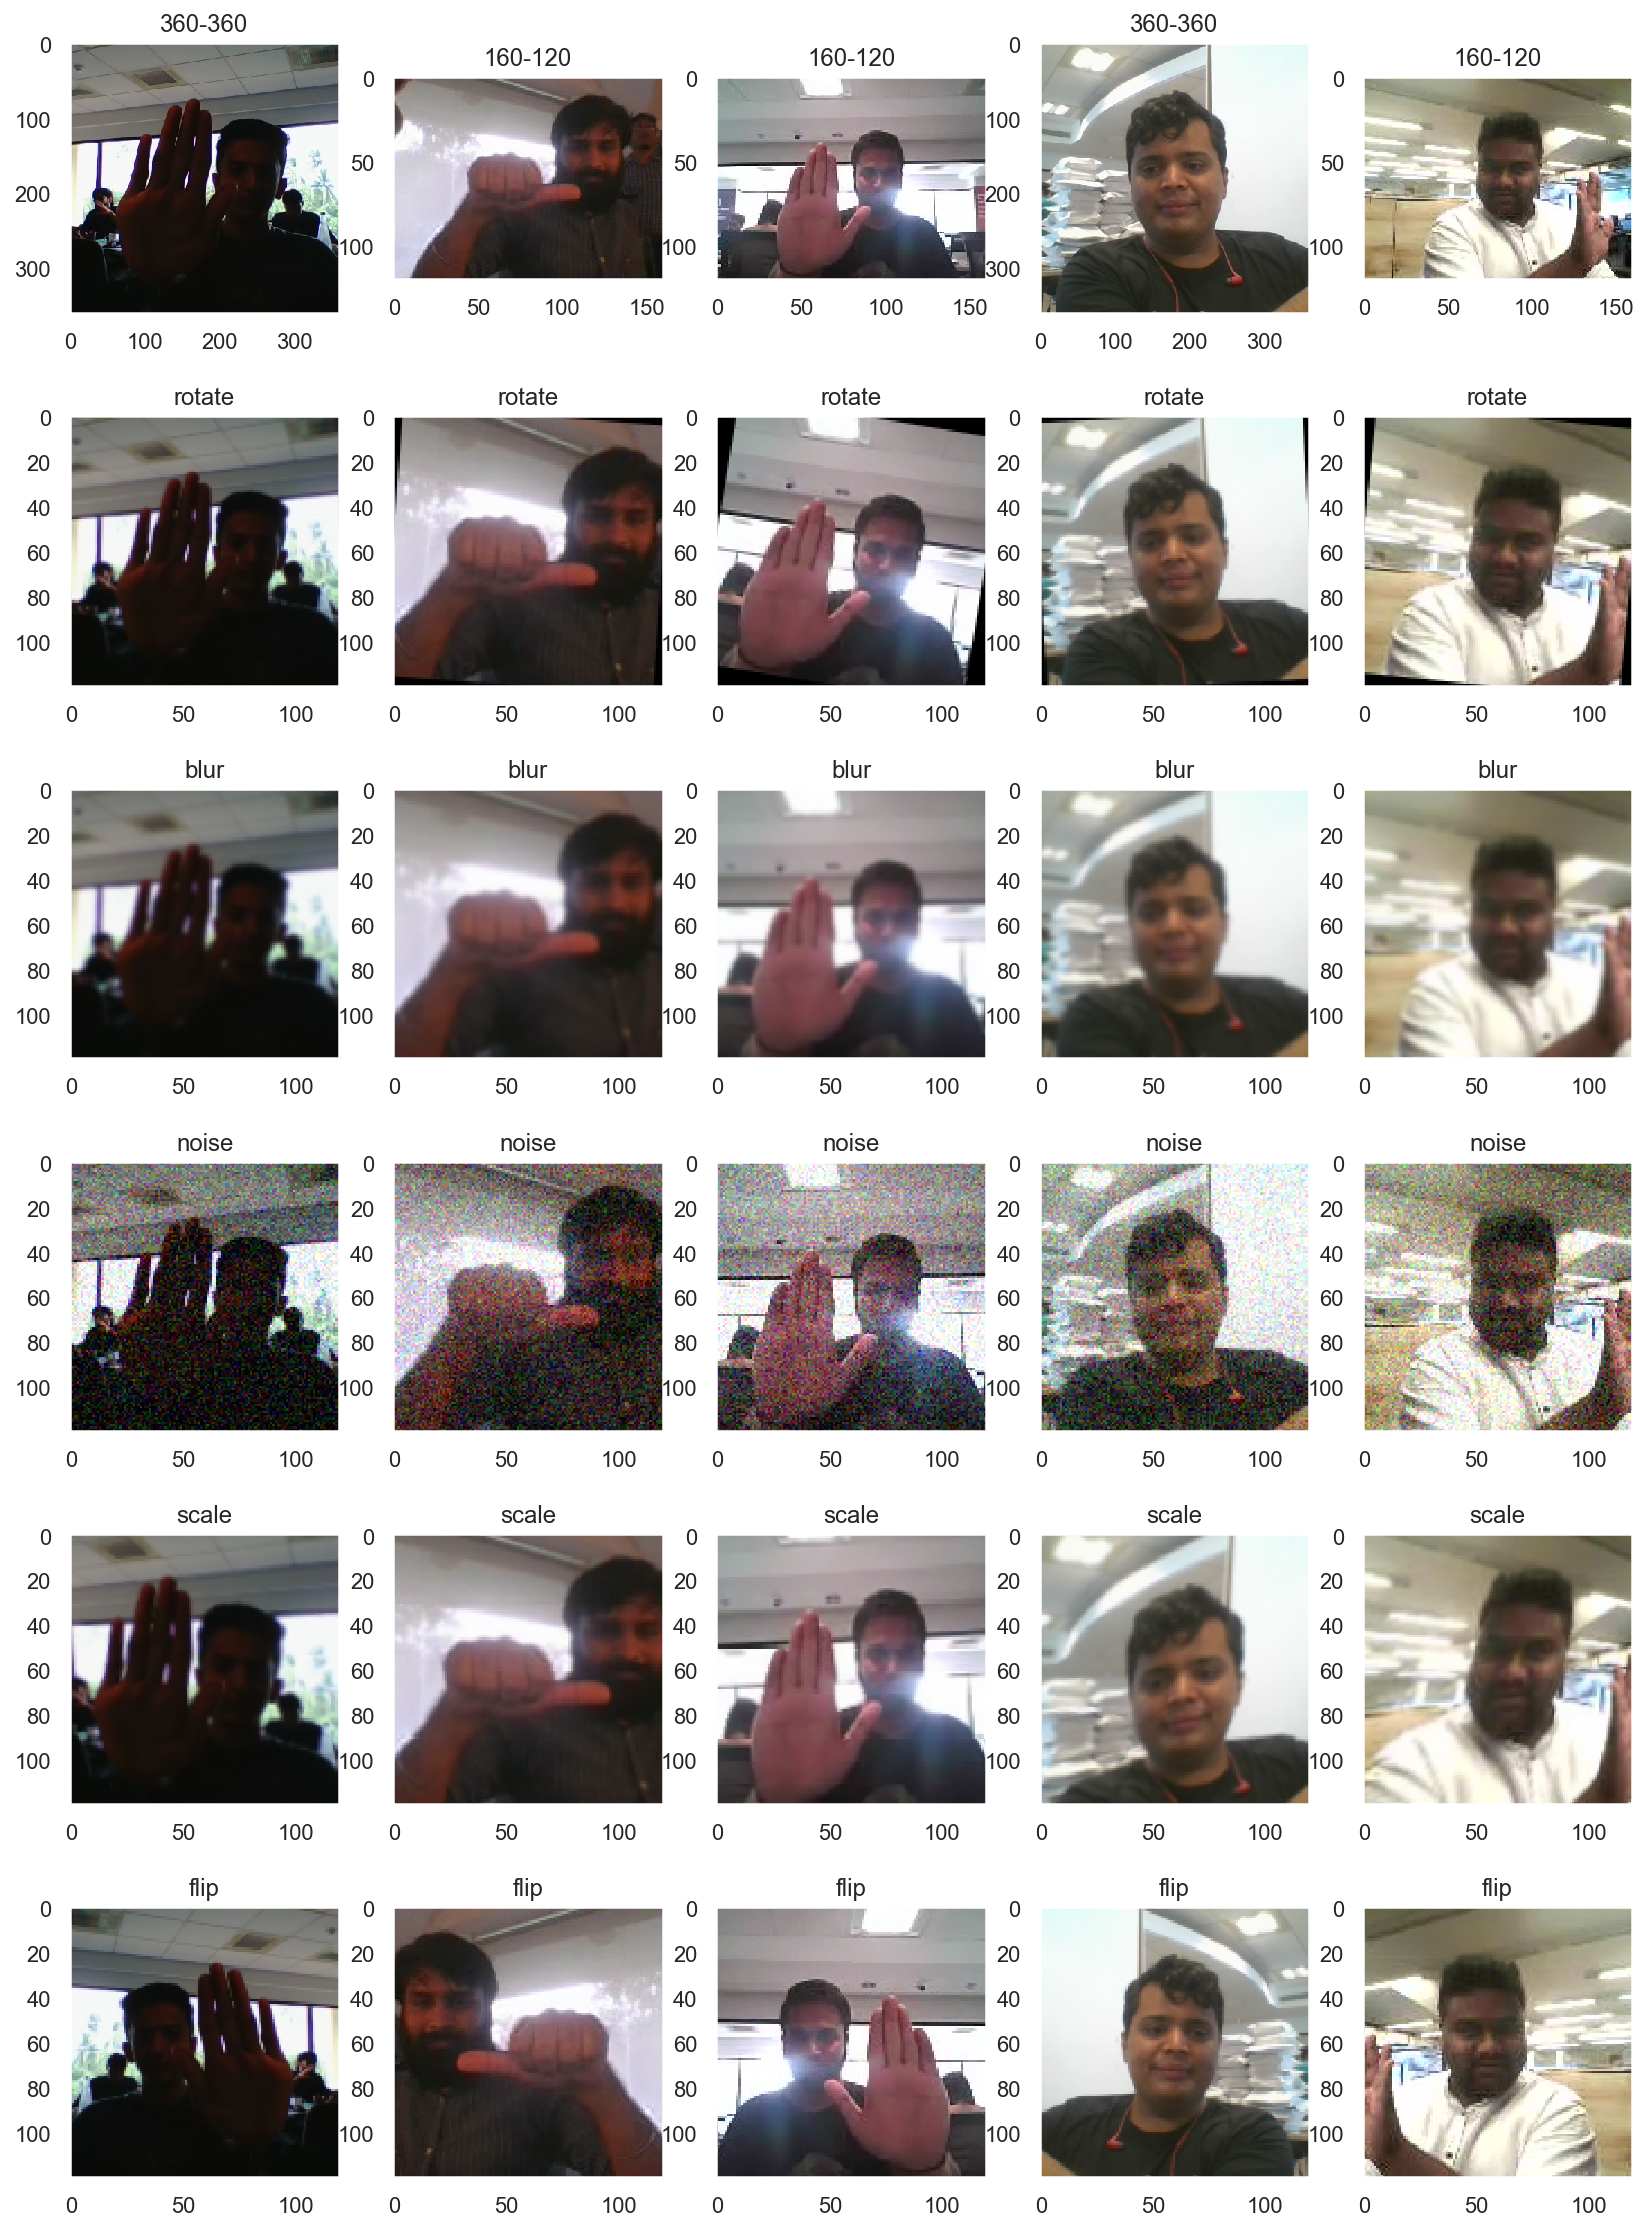

In [27]:
sample_size = 5
df = explore_images(base_path + 'train.csv', base_path + 'train/')
sample = df.sample(n=sample_size)
fig, axs = plt.subplots(1 + len(image_augmentors),
                        sample_size,
                        figsize=(14, 20))
plot_index = 1
for index, row in sample.head(n=sample_size).iterrows():
    image = get_image(base_path + 'train/' + row['folder'], 5)
    plt.subplot(1 + len(image_augmentors),
                sample_size,
                plot_index,
                title=row['shape'])
    plt.imshow(image.astype('uint8'), interpolation='nearest')
    image = modify_image(image, starting_image_shape) / 255
    size = plot_index
    for i, image_augmentor in enumerate(image_augmentors):
        size = size + sample_size
        plt.subplot(1 + len(image_augmentors),
                    sample_size,
                    size,
                    title=image_augmentor.__name__)
        current_image = image_augmentor(image)
        plt.imshow(current_image, cmap=None)
    plot_index += 1

plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [28]:
train_path = base_path + 'train'
val_path = base_path + 'val'

In [29]:
def nomalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

In [30]:
random.seed(30)


def get_batch_data(t, source_path, batch, batch_size, number_of_folders,
                   img_idx, image_shape, augmentors, test_generator, verbose,
                   processedImagesSet, labels_list):
    if verbose:
        print("Executing batch ", batch)
        print("Augmentors ", len(augmentors))
    is_training = len(augmentors) != 0
    batch_data = np.zeros(
        (number_of_folders, len(img_idx), image_shape[0], image_shape[1], 3))
    # batch_labels is the one hot representation of the output
    batch_labels = np.zeros((number_of_folders, 5))
    if is_training:
        aug_batch_data = []
        aug_batch_labels = []
        # Initializing data and labels for each augmentor
        for aug in augmentors:
            aug_batch_data.append(
                np.zeros((number_of_folders, len(img_idx), image_shape[0],
                          image_shape[1], 3)))
            aug_batch_labels.append(np.zeros((number_of_folders, 5)))
    for folder in range(number_of_folders):  # iterate over the batch_size
        if verbose:
            print("Executing folder ", folder)
        # read all the images in the folder
        imgs = os.listdir(source_path + '/' +
                          t[folder + (batch * batch_size)].split(';')[0])
        # Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx):
            if test_generator:
                image_path = source_path + '/' + \
                    t[folder + (batch * batch_size)
                      ].strip().split(';')[0] + "_" + str(item)
                assert image_path not in processedImagesSet, "Duplicate image should not be added"
                processedImagesSet.add(image_path)
            image = get_image(
                source_path + '/' +
                t[folder + (batch * batch_size)].strip().split(';')[0], item)

            # Here, we are croping and resizing the image based on its dimensions
            image = modify_image(image, image_shape)
            # normalize image
            image = image / 255
            # crop the images and resize them. Note that the images are of 2 different shape
            # and the conv3D will throw error if the inputs in a batch have different shapes
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 0] = image[:, :, 0]
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 1] = image[:, :, 1]
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 2] = image[:, :, 2]
            if is_training:
                for index, augmentor in enumerate(augmentors):
                    augmented_image = augmentor(image)
                    aug_batch_data[index][folder, idx, :, :,
                                          0] = augmented_image[:, :, 0]
                    aug_batch_data[index][folder, idx, :, :,
                                          1] = augmented_image[:, :, 1]
                    aug_batch_data[index][folder, idx, :, :,
                                          2] = augmented_image[:, :, 2]
        current_class = int(t[folder +
                              (batch * batch_size)].strip().split(';')[2])
        batch_labels[folder, current_class] = 1
        if test_generator:
            labels_list.append({
                'l_type': 'n',
                'old_label': current_class,
                'new_label': current_class
            })
        if is_training:
            for index, augmentor in enumerate(augmentors):
                # When flip augmentation is used, left swip will change to right swipe
                if augmentor.__name__ == flip.__name__:
                    if current_class == 0:
                        new_class = 1
                    elif current_class == 1:
                        new_class = 0
                    else:
                        new_class = current_class
                    aug_batch_labels[index][folder, new_class] = 1
                    if test_generator:
                        labels_list.append({
                            'l_type': augmentor.__name__,
                            'old_label': current_class,
                            'new_label': new_class
                        })
                else:
                    aug_batch_labels[index][folder, current_class] = 1
                    if test_generator:
                        labels_list.append({
                            'l_type': augmentor.__name__,
                            'old_label': current_class,
                            'new_label': current_class
                        })
    if is_training:
        for index, augmentor in enumerate(augmentors):
            batch_data = np.append(batch_data, aug_batch_data[index], axis=0)
            batch_labels = np.append(batch_labels,
                                     aug_batch_labels[index],
                                     axis=0)
    return batch_data, batch_labels

In [31]:
def generator(source_path,
              folder_list,
              batch_size,
              list_of_frames,
              image_shape,
              augmentors=[],
              test_generator=False,
              verbose=False,
              processedImagesSet=set(),
              labels_list=[]):
    print('Source path = ', source_path, '; batch size =', batch_size)
    # create a list of image numbers you want to use for a particular video
    img_idx = list_of_frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches
        if verbose:
            print("Number of batches ", num_batches)
        for batch in range(
                num_batches):  # we iterate over the number of batches
            yield get_batch_data(t, source_path, batch, batch_size, batch_size,
                                 img_idx, image_shape, augmentors,
                                 test_generator, verbose, processedImagesSet,
                                 labels_list)

        remaining_folder = len(t) % batch_size
        if remaining_folder > 0:
            if verbose:
                print("Executing remaining batch")
            yield get_batch_data(t, source_path, num_batches, batch_size,
                                 remaining_folder, img_idx, image_shape,
                                 augmentors, test_generator, verbose,
                                 processedImagesSet, labels_list)
        if test_generator:
            break

# Testing image generator

In [32]:
def test_image_generator(path,
                         data,
                         number_of_frames,
                         current_batch_size,
                         augmentors=[]):
    processedImagesSet = set()
    labels_list = []

    generator_to_validate = generator(path,
                                      data,
                                      current_batch_size,
                                      list(range(0, number_of_frames)),
                                      starting_image_shape,
                                      augmentors=augmentors,
                                      test_generator=True,
                                      verbose=False,
                                      processedImagesSet=processedImagesSet,
                                      labels_list=labels_list)
    total_images = len(data) * number_of_frames
    image_count = 0
    label_count = 0
    index = 0
    whole = len(data) // current_batch_size
    for data in generator_to_validate:
        image_count += data[0].shape[0] * data[0].shape[1]
        label_count += data[1].shape[0] * data[1].shape[1]
        if index >= whole:
            break
        consumed_batch = 0
        for b in range(0, current_batch_size):

            label = labels_list[index * data[1].shape[0] + consumed_batch +
                                consumed_batch * len(augmentors)]
            found_label = np.nonzero(data[1][b])[0]
            assert found_label == label[
                "old_label"], "For normal, it should be same"

            for l in range(0, len(augmentors)):
                label = labels_list[index * data[1].shape[0] + consumed_batch +
                                    consumed_batch * len(augmentors) + l + 1]
                aug_index = b + l * current_batch_size + current_batch_size
                found_label = np.nonzero(data[1][aug_index])[0]
                if label['l_type'] == flip.__name__:
                    if label["old_label"] == 0:
                        assert found_label == label[
                            "new_label"] and found_label == 1, "For Flip, 0 should changed to 1"
                    elif label["old_label"] == 1:
                        assert found_label == label[
                            "new_label"] and found_label == 0, "For Flip, 1 should changed to 0"
                    else:
                        assert found_label == label[
                            "old_label"], "For other flips, it should be same"
                else:
                    assert found_label == label[
                        "old_label"], "For other augmentation, it should be same"
            consumed_batch += 1
        index += 1

    print("Images generated: ", image_count)
    print("Images should be generated: ",
          total_images + (total_images) * len(augmentors))
    print("Label generated: ", label_count)
    assert label_count == len(labels_list) * \
        5, "The generator did not return all lables"
    if len(augmentors) == 0:
        assert len(
            processedImagesSet
        ) == image_count, "the generator did not return all the images"
        assert image_count == total_images + \
            (total_images) * \
            len(augmentors), "the generator did not return all the images"

In [33]:
test_image_generator(train_path, train_doc, 10, 16)
test_image_generator(train_path, train_doc, 10, 10)
test_image_generator(val_path, val_doc, 10, 16, [flip, scale, rotate])
test_image_generator(val_path, val_doc, 10, 10, augmentors=[flip])

Source path =  Project_data/train ; batch size = 16
Images generated:  6630
Images should be generated:  6630
Label generated:  3315
Source path =  Project_data/train ; batch size = 10
Images generated:  6630
Images should be generated:  6630
Label generated:  3315
Source path =  Project_data/val ; batch size = 16
Images generated:  4000
Images should be generated:  4000
Label generated:  2000
Source path =  Project_data/val ; batch size = 10
Images generated:  2000
Images should be generated:  2000
Label generated:  1000


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [34]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5  # choose the number of epochs
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [35]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

In [36]:
def get_optimizer(optimizer, learning_rate=0.01, decay=False):
    if optimizer == "sgd":
        print("SGD optimizer with learning rate: ", learning_rate, decay)
        if decay:
            model_optimizer = optimizers.SGD(lr=learning_rate, decay=0.00001)
        else:
            model_optimizer = optimizers.SGD(lr=learning_rate)
    else:
        print("ADAM optimizer with learning rate: ", learning_rate, decay)
        if decay:
            model_optimizer = optimizers.Adam(lr=learning_rate, decay=0.00001)
        else:
            model_optimizer = optimizers.Adam(lr=learning_rate)

    return model_optimizer

### This approach of running model and collecting metrics is adopted from our previous project `Telecom Churn case study`

In [37]:
class ModelParam:
    def __init__(self, params):
        self.learning_rate = params["learning_rate"]
        self.optmizer = params["optmizer"]
        self.batch_size = params["batch_size"]
        self.video_frames = list(
            range(params["frames"][0], params["frames"][1]))
        self.learning_rate = params["learning_rate"]
        self.num_epochs = params["num_epochs"]
        self.batch_normalize = params["batch_normalize"]
        self.filters = params["filters"]
        self.dropouts = params["dropouts"]
        self.dense_input = params["dense_input"]
        self.image_shape = params["image_shape"]
        self.decay_learning_rate = params.get("decay_learning_rate", False)
        self.kernel_shape_side = params.get("kernel_shape_side", 3)
        self.augmentors = params.get("augmentors", [])

        dropout = (len([d for d in self.dropouts if d is not None]) > 0)
        regularize = self.batch_normalize or dropout
        self.rnn_layer_type = params.get("rnn_layer_type", None)
        self.rnn_layers = params.get("rnn_layers", None)
        self.name = params["model_name"] + "_" + self.optmizer + "_" + str(
            len(self.filters) +
            len(self.dense_input)) + "_" + "layers" + "_" + str(
                self.num_epochs) + "_" + "epochs" + "_" + (
                    "regularized" if regularize else "not_regularized")
        self.is_rnn = self.rnn_layer_type is not None
        self.input_shape = (len(self.video_frames), self.image_shape[0],
                            self.image_shape[1], 3)
        if (regularize):
            if (self.batch_normalize):
                self.name = self.name + "_BN"
            if (dropout):
                self.name = self.name + "_DO"
        if self.rnn_layer_type is None:
            assert (len(self.filters) + len(self.dense_input)) == len(
                self.dropouts
            ), 'the filters and dense layers should sum up to number of dropouts'
        else:
            assert (
                len(self.filters) + len(self.dense_input) +
                len(self.rnn_layers)
            ) == len(
                self.dropouts
            ), 'the filters, dense layers and rnn layers should sum up to number of dropouts'

    def print_params(self):
        attrs = vars(self)
        print("Model Params: ")
        for key, value in attrs.items():
            if value:
                print(key, '->', value)

In [38]:
def convert_history_to_data_frame(model_name, history):
    df = pd.DataFrame.from_dict(history)
    df['epoch'] = df.index
    df['name'] = model_name
    return df

In [39]:
def run_model(model, params, show_summary=True):
    params.print_params()

    model_optimizer = get_optimizer(params.optmizer,
                                    learning_rate=params.learning_rate,
                                    decay=params.decay_learning_rate)

    model.compile(optimizer=model_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    if show_summary:
        print(model.summary())

    curr_dt_time = datetime.datetime.now()

    train_generator = generator(train_path,
                                train_doc,
                                params.batch_size,
                                list_of_frames=params.video_frames,
                                image_shape=params.image_shape,
                                augmentors=params.augmentors)
    val_generator = generator(val_path,
                              val_doc,
                              params.batch_size,
                              list_of_frames=params.video_frames,
                              image_shape=params.image_shape,
                              augmentors=[])
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(
        ' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + \
        'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False,
                                 save_weights_only=False,
                                 mode='auto',
                                 period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.4,
                           patience=2,
                           min_lr=0.000001,
                           verbose=1)  # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    if (num_train_sequences % params.batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / params.batch_size)
    else:
        steps_per_epoch = (num_train_sequences // params.batch_size) + 1

    if (num_val_sequences % params.batch_size) == 0:
        validation_steps = int(num_val_sequences / params.batch_size)
    else:
        validation_steps = (num_val_sequences // params.batch_size) + 1

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=params.num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'],
             label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'],
             label='Categorical crossentropy (validation data)')
    plt.plot(history.history['categorical_accuracy'],
             label='Accuracy (training data)')
    plt.plot(history.history['val_categorical_accuracy'],
             label='Accuracy (validation data)')

    plt.title('Model performance: ' + params.name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    return convert_history_to_data_frame(params.name, history.history)

Reference: https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/

In [40]:
def create_cnn_model(model_param):
    model = Sequential()
    for index, f in enumerate(model_param.filters):
        if index == 0:
            model.add(
                Conv3D(f,
                       kernel_size=(model_param.kernel_shape_side,
                                    model_param.kernel_shape_side,
                                    model_param.kernel_shape_side),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       input_shape=model_param.input_shape,
                       padding='same'))
        else:
            model.add(
                Conv3D(f,
                       kernel_size=(model_param.kernel_shape_side,
                                    model_param.kernel_shape_side,
                                    model_param.kernel_shape_side),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       padding='same'))
        if model_param.batch_normalize:
            model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        if model_param.dropouts[index]:
            model.add(Dropout(model_param.dropouts[index]))

    model.add(Flatten())
    for index, d in enumerate(model_param.dense_input):
        model.add(Dense(d, activation='relu', kernel_initializer='he_uniform'))
        dropout_index = len(model_param.filters) + index
        if model_param.batch_normalize and dropout_index < len(
                model_param.dense_input):
            model.add(BatchNormalization())
        if model_param.dropouts[dropout_index]:
            model.add(Dropout(model_param.dropouts[dropout_index]))

    model.add(Dense(5, activation='softmax'))
    return model

In [41]:
model_stats = None

In [42]:
def collect_stats(df):
    global model_stats
    if model_stats is not None:
        model_stats = pd.concat([model_stats, df], axis=0)
    else:
        model_stats = df
    return df

In [43]:
def sub_plot(x1,
             y1,
             x2,
             y2,
             title,
             index,
             x_label="Number of epochs",
             y_label='Loss value'):
    plt.subplot(2, 2, index, title=title)

    plt.plot(x1, y1, label=first_model)
    plt.plot(x2, y2, label=second_model)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(loc="upper left")


def plot_graphs(first_model, second_model, number_of_epochs):
    first_model_data = model_stats.loc[model_stats['name'] ==
                                       first_model][0:number_of_epochs]
    second_model_data = model_stats.loc[model_stats['name'] ==
                                        second_model][0:number_of_epochs]

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    sub_plot(first_model_data['epoch'], first_model_data['loss'],
             second_model_data['epoch'], second_model_data['loss'],
             "Training Loss", 1)

    sub_plot(first_model_data['epoch'], first_model_data['val_loss'],
             second_model_data['epoch'], second_model_data['val_loss'],
             "Validation Loss", 3)

    sub_plot(first_model_data['epoch'],
             first_model_data['categorical_accuracy'],
             second_model_data['epoch'],
             second_model_data['categorical_accuracy'],
             "Training Accuracy",
             2,
             y_label='Accuracy')

    sub_plot(first_model_data['epoch'],
             first_model_data['val_categorical_accuracy'],
             second_model_data['epoch'],
             second_model_data['val_categorical_accuracy'],
             "Validation Accuracy",
             4,
             y_label='Accuracy')
    plt.show()

Let us start with 3 layer CNN model with no regularization and batch size 10

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [8, 16, 32]
dropouts -> [None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_sgd_4_layers_6_epochs_not_regularized
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001 False
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
__________________________________________

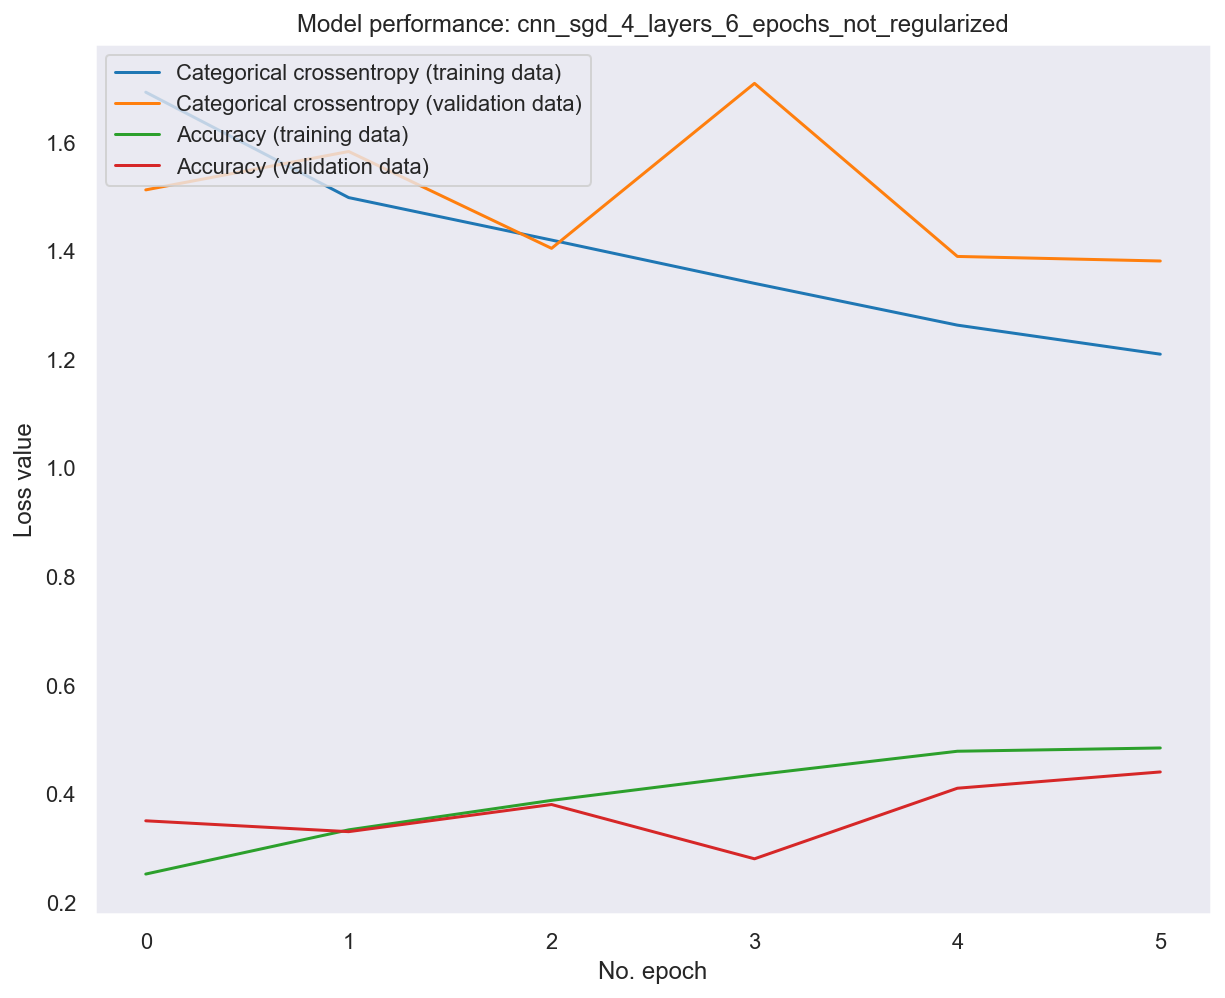

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.5122,0.3500,1.6921,0.2519,0.0010,0,cnn_sgd_4_layers_6_epochs_not_regularized
1,1.5829,0.3300,1.4980,0.3333,0.0010,1,cnn_sgd_4_layers_6_epochs_not_regularized
2,1.4045,0.3800,1.4197,0.3876,0.0010,2,cnn_sgd_4_layers_6_epochs_not_regularized
3,1.7084,0.2800,1.3400,0.4344,0.0010,3,cnn_sgd_4_layers_6_epochs_not_regularized
4,1.3896,0.4100,1.2630,0.4781,0.0010,4,cnn_sgd_4_layers_6_epochs_not_regularized
5,1.3812,0.4400,1.2095,0.4842,0.0010,5,cnn_sgd_4_layers_6_epochs_not_regularized


In [44]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [8, 16, 32]
dropouts -> [None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_adam_4_layers_6_epochs_not_regularized
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 False
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_______________________________________

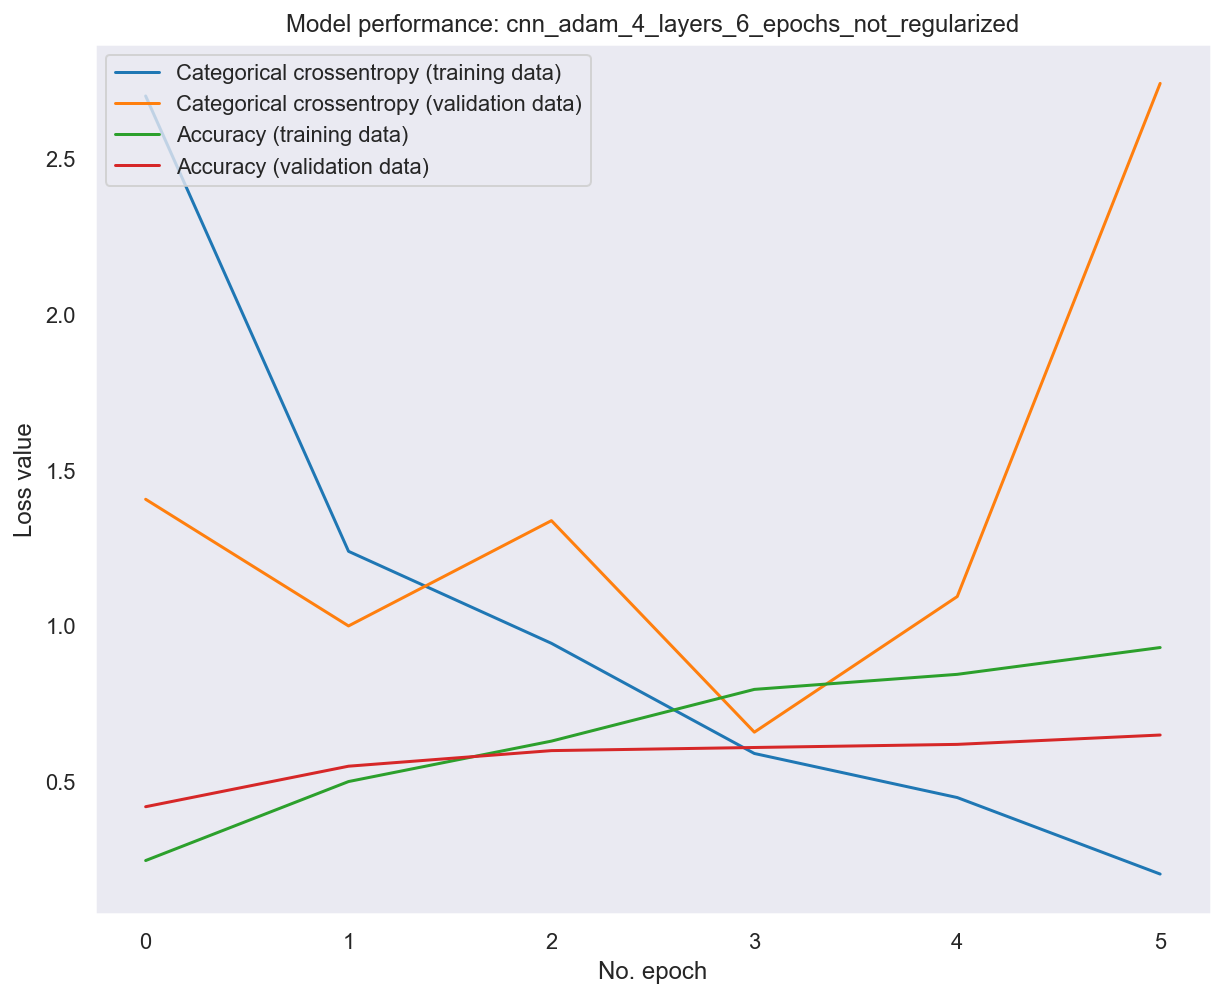

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.4062,0.4200,2.6998,0.2474,0.0010,0,cnn_adam_4_layers_6_epochs_not_regularized
1,0.9999,0.5500,1.2392,0.5008,0.0010,1,cnn_adam_4_layers_6_epochs_not_regularized
2,1.3376,0.6000,0.9441,0.6305,0.0010,2,cnn_adam_4_layers_6_epochs_not_regularized
3,0.6591,0.6100,0.5908,0.7964,0.0010,3,cnn_adam_4_layers_6_epochs_not_regularized
4,1.0942,0.6200,0.4494,0.8446,0.0010,4,cnn_adam_4_layers_6_epochs_not_regularized
5,2.7402,0.6500,0.2040,0.9306,0.0010,5,cnn_adam_4_layers_6_epochs_not_regularized


In [45]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

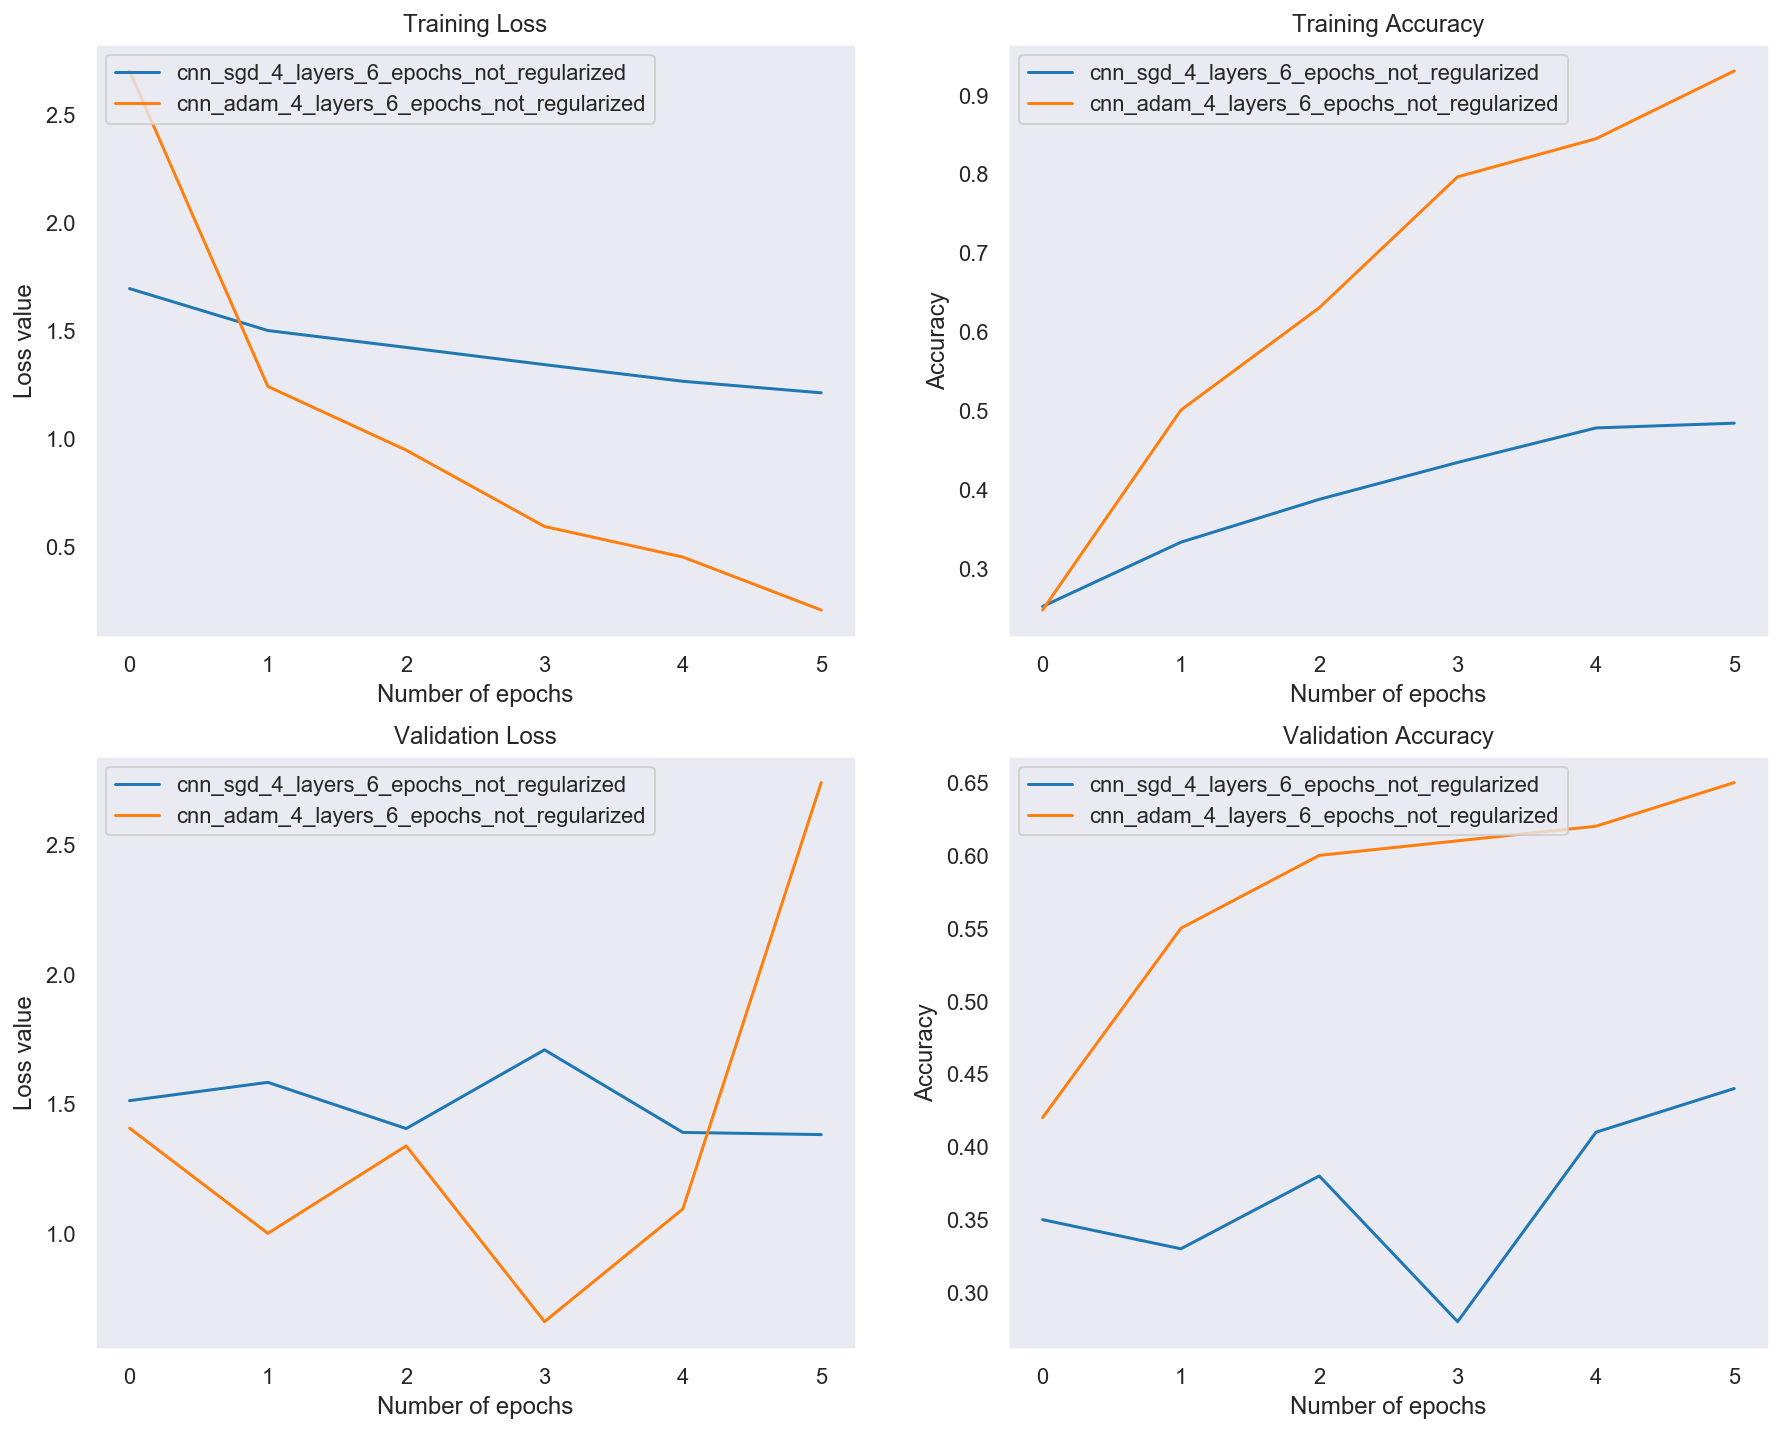

In [46]:
number_of_epochs = 6
first_model = 'cnn_sgd_4_layers_6_epochs_not_regularized'
second_model = 'cnn_adam_4_layers_6_epochs_not_regularized'

plot_graphs(first_model, second_model, number_of_epochs)

We can see that using `ADAM` optmizer significantly improves the accuracy. However, the difference between training accuracy and validation accuracy is too big which suggests overfitting of the data. Let us use regularization. We will use `BatchNormalization` and `Dropout` for regularization.

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32]
dropouts -> [None, 0.25, 0.25, 0.25]
dense_input -> [128]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_adam_4_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 False
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_____________

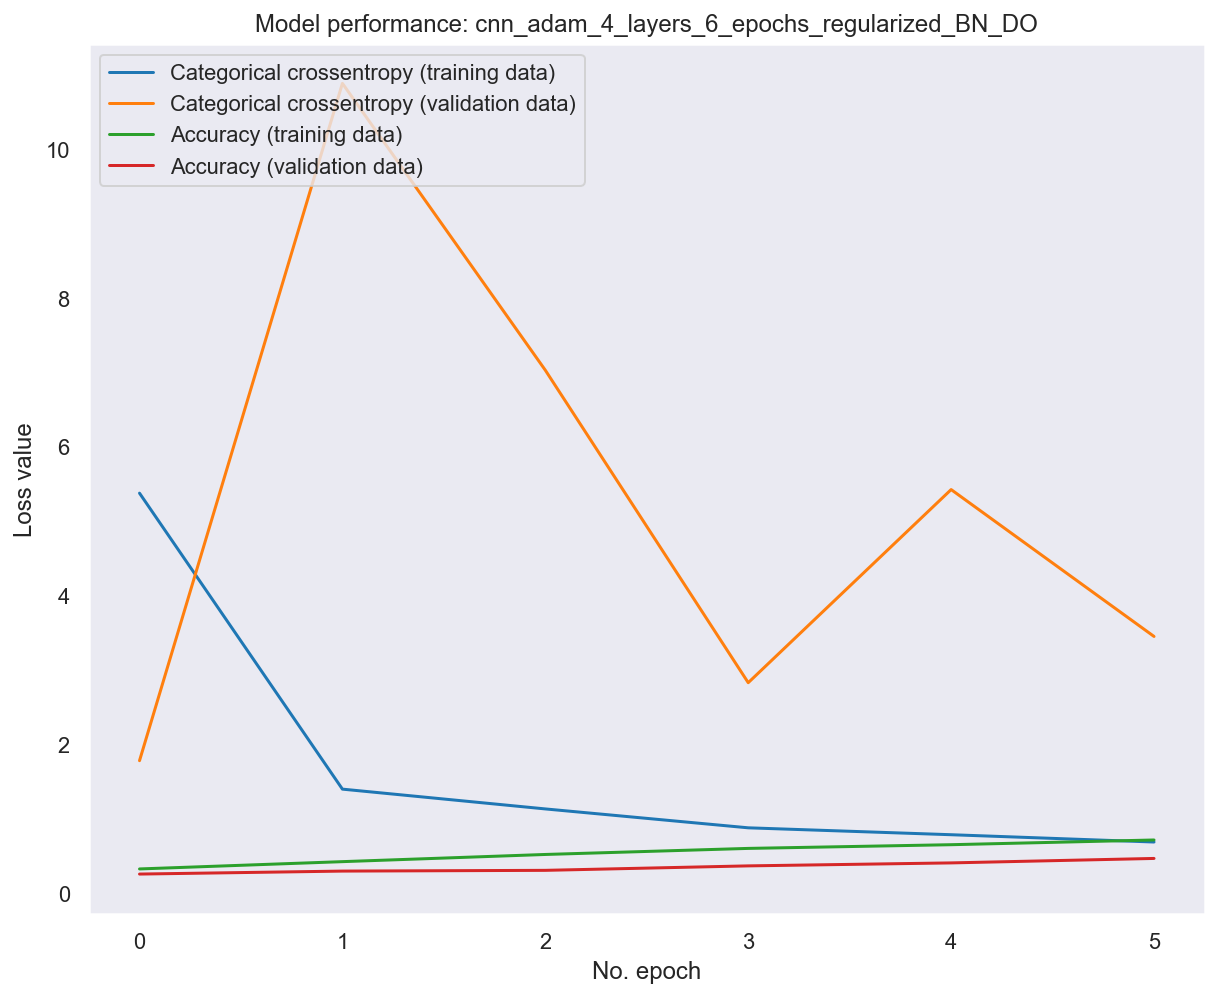

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.7832,0.2600,5.3783,0.3288,0.0010,0,cnn_adam_4_layers_6_epochs_regularized_BN_DO
1,10.8842,0.3000,1.4012,0.4268,0.0010,1,cnn_adam_4_layers_6_epochs_regularized_BN_DO
2,7.0301,0.3100,1.1352,0.5234,0.0010,2,cnn_adam_4_layers_6_epochs_regularized_BN_DO
3,2.8314,0.3700,0.8814,0.6048,0.0004,3,cnn_adam_4_layers_6_epochs_regularized_BN_DO
4,5.4262,0.4100,0.7887,0.6546,0.0004,4,cnn_adam_4_layers_6_epochs_regularized_BN_DO
5,3.4526,0.4700,0.6906,0.7179,0.0002,5,cnn_adam_4_layers_6_epochs_regularized_BN_DO


In [47]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .25],
    "dense_input": [128],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

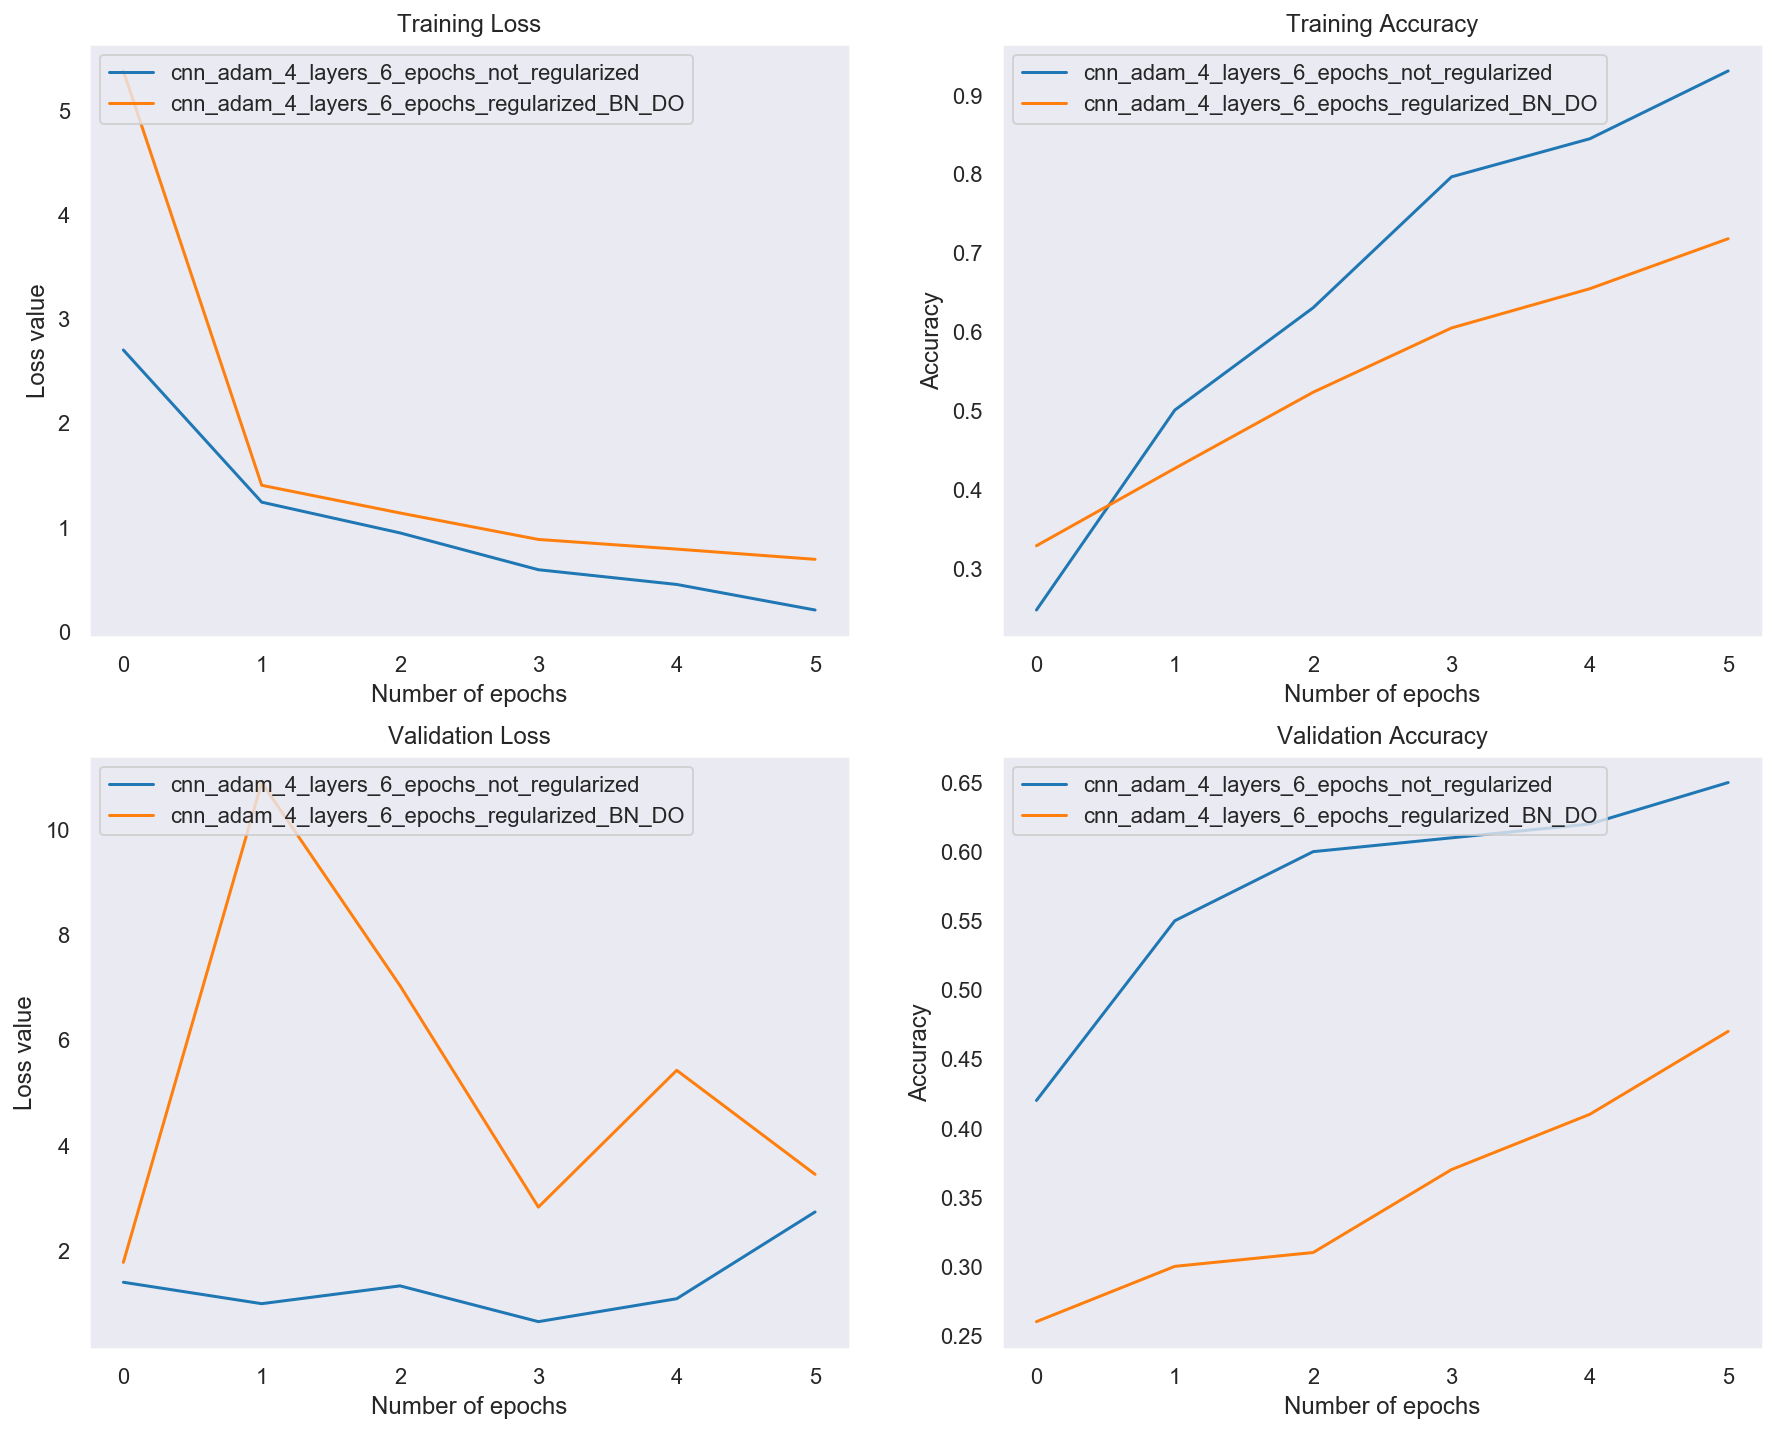

In [48]:
number_of_epochs = 6
first_model = 'cnn_adam_4_layers_6_epochs_not_regularized'
second_model = 'cnn_adam_4_layers_6_epochs_regularized_BN_DO'

plot_graphs(first_model, second_model, number_of_epochs)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, 0.25, 0.25, 0.25, 0.25, None]
dense_input -> [128, 64]
image_shape -> (120, 120)
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 False
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 15, 60, 60, 8)     0   

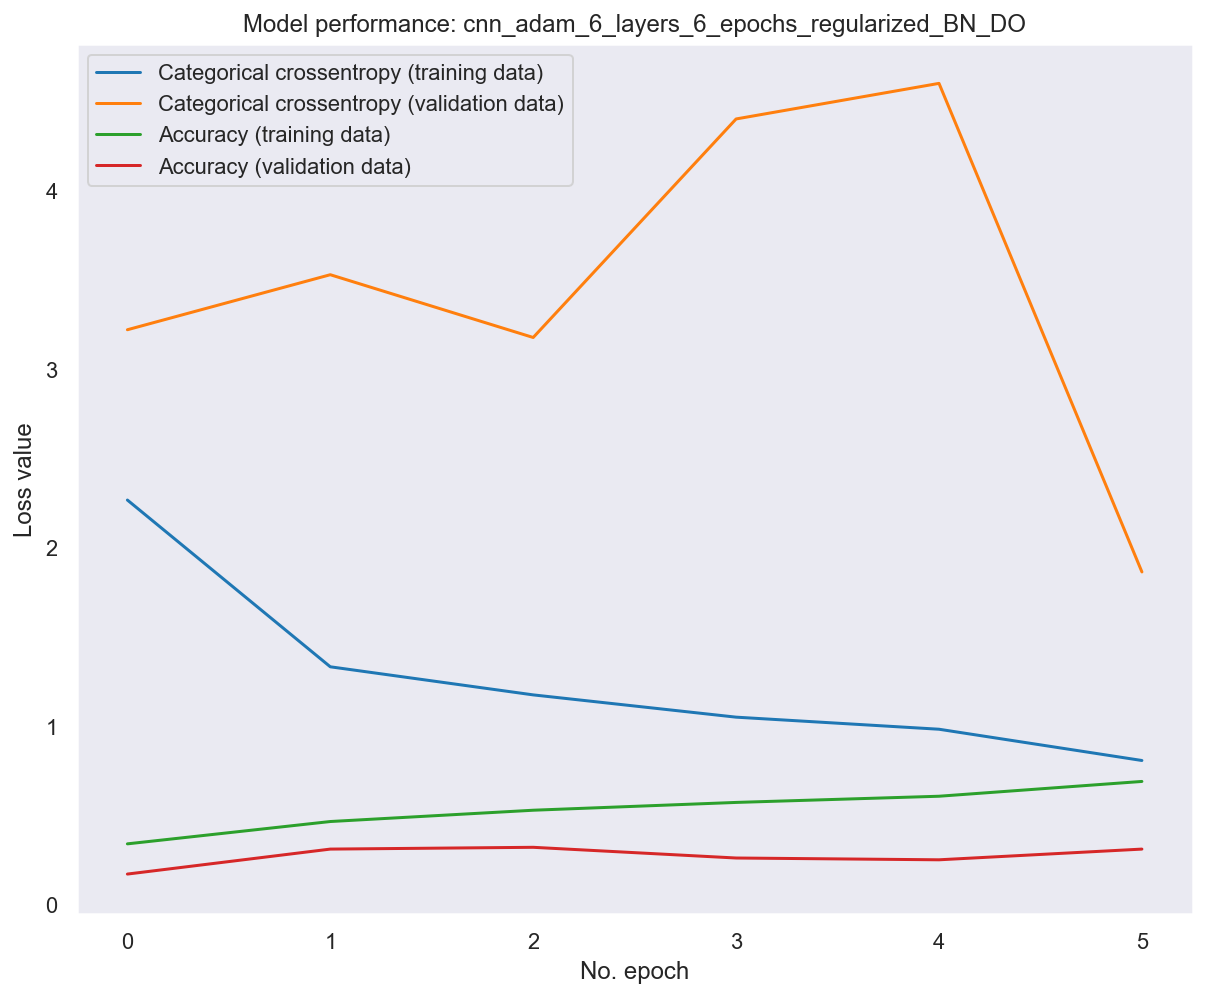

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,3.2216,0.1700,2.2670,0.3394,0.0010,0,cnn_adam_6_layers_6_epochs_regularized_BN_DO
1,3.5302,0.3100,1.3320,0.4646,0.0010,1,cnn_adam_6_layers_6_epochs_regularized_BN_DO
2,3.1782,0.3200,1.1746,0.5279,0.0010,2,cnn_adam_6_layers_6_epochs_regularized_BN_DO
3,4.4034,0.2600,1.0497,0.5716,0.0010,3,cnn_adam_6_layers_6_epochs_regularized_BN_DO
4,4.6029,0.2500,0.9820,0.6063,0.0010,4,cnn_adam_6_layers_6_epochs_regularized_BN_DO
5,1.8637,0.3100,0.8067,0.6893,0.0004,5,cnn_adam_6_layers_6_epochs_regularized_BN_DO


In [49]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .25,.25,None],
    "dense_input": [128,64],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

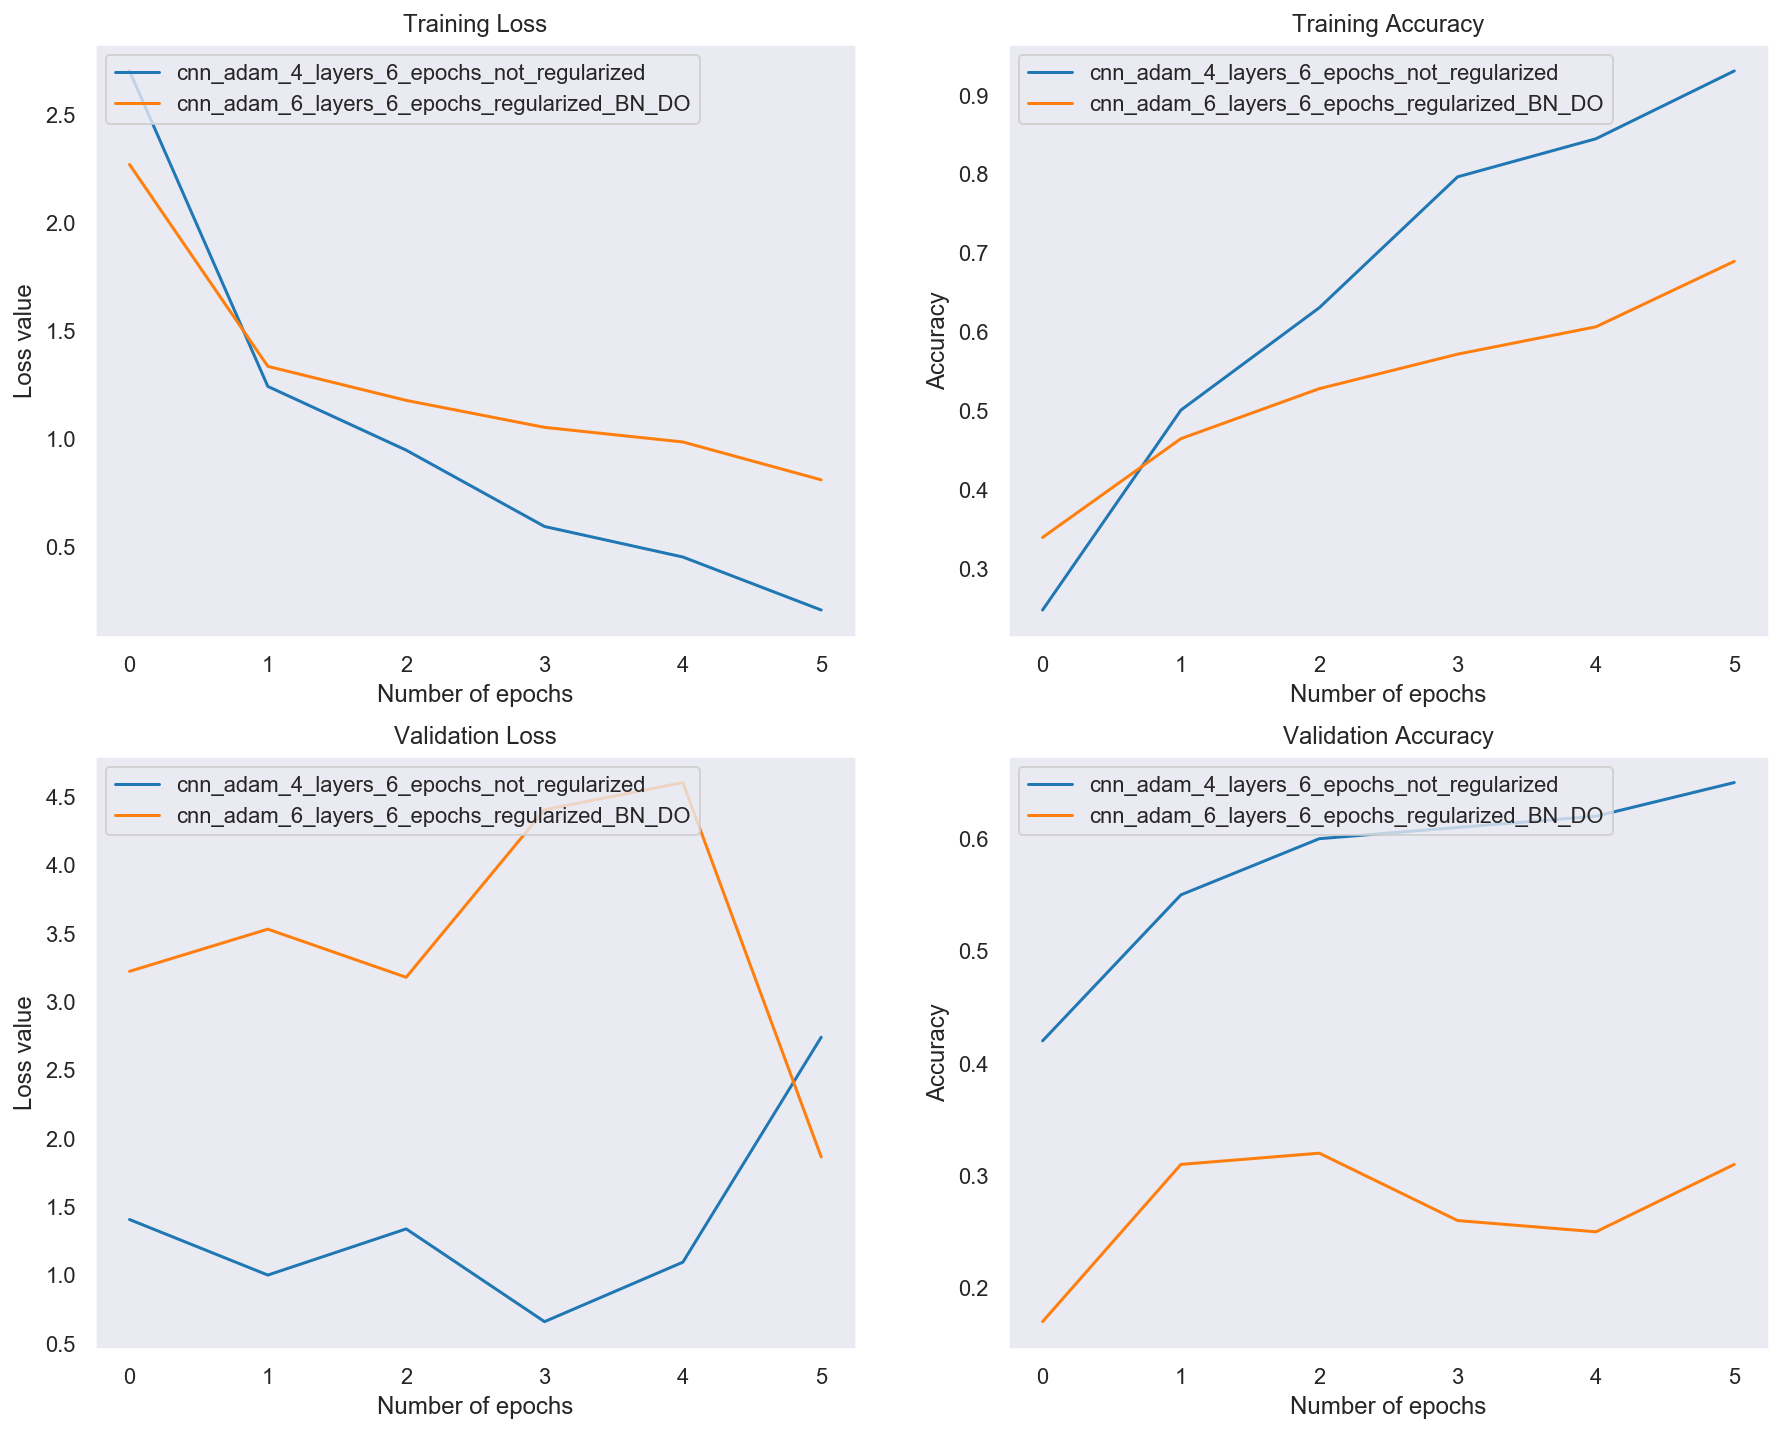

In [50]:
number_of_epochs = 6
first_model = 'cnn_adam_4_layers_6_epochs_not_regularized'
second_model = 'cnn_adam_6_layers_6_epochs_regularized_BN_DO'

plot_graphs(first_model, second_model, number_of_epochs)

We can see that the accuracy is not improving as it is supposed to. There is no steep drop in the loss. Let us increase the model filters and introduce learning rate decay.

In [ ]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [16, 16, 32, 32],
    "batch_normalize": True,
    "dropouts": [None, .25, .50, .25, .5, 5],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [16, 16, 32, 32]
dropouts -> [None, 0.25, 0.5, 0.25, 0.5, 5]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None,

In [354]:
# Not use it

params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 10,
    "filters": [8, 16, 32, 64],
    "batch_normalize": True,
    "dropouts": [.25, .25, .25, .25, .50, .50],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "augmentors": [blur, scale, rotate]
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 10
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [0.25, 0.25, 0.25, 0.25, 0.5, 0.5]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
augmentors -> [<function blur at 0x7fe3d2ad28c0>, <function scale at 0x7fe383a48680>, <function rotate at 0x7fe3d2ad2b00>]
name -> cnn_adam_6_layers_10_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_33 (Batc (None, 30,

KeyboardInterrupt: 

In [208]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (5, 27),
    "model_name": "cnn",
    "num_epochs": 15,
    "filters": [8, 16, 32, 64],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .50, .25, None],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "image_augmentation": True

}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
num_epochs -> 15
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, 0.25, 0.25, 0.5, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_15_epochs_regularized_BN_DO
input_shape -> (22, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 22, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 11, 60, 60, 8)     0 

TypeError: generator() got an unexpected keyword argument 'image_augmentation'

In [170]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32, 64, 128],
    "batch_normalize": True,
    "dropouts": [None, .25, .25, .50, .25, .25, None],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "image_augmentation": True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [32, 32, 64, 64]
dropouts -> [None, None, 0.25, 0.5, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
image_augmentation -> True
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_58 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max

KeyboardInterrupt: 

In [51]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [16, 32, 64,128],
    "batch_normalize": True,
    "dropouts": [None, .25, .50, .50,.25,None],
    "dense_input": [256,128],
    "image_shape": (120, 120),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [16, 32, 64, 128]
dropouts -> [None, 0.25, 0.5, 0.5, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 15, 60, 60, 16)  

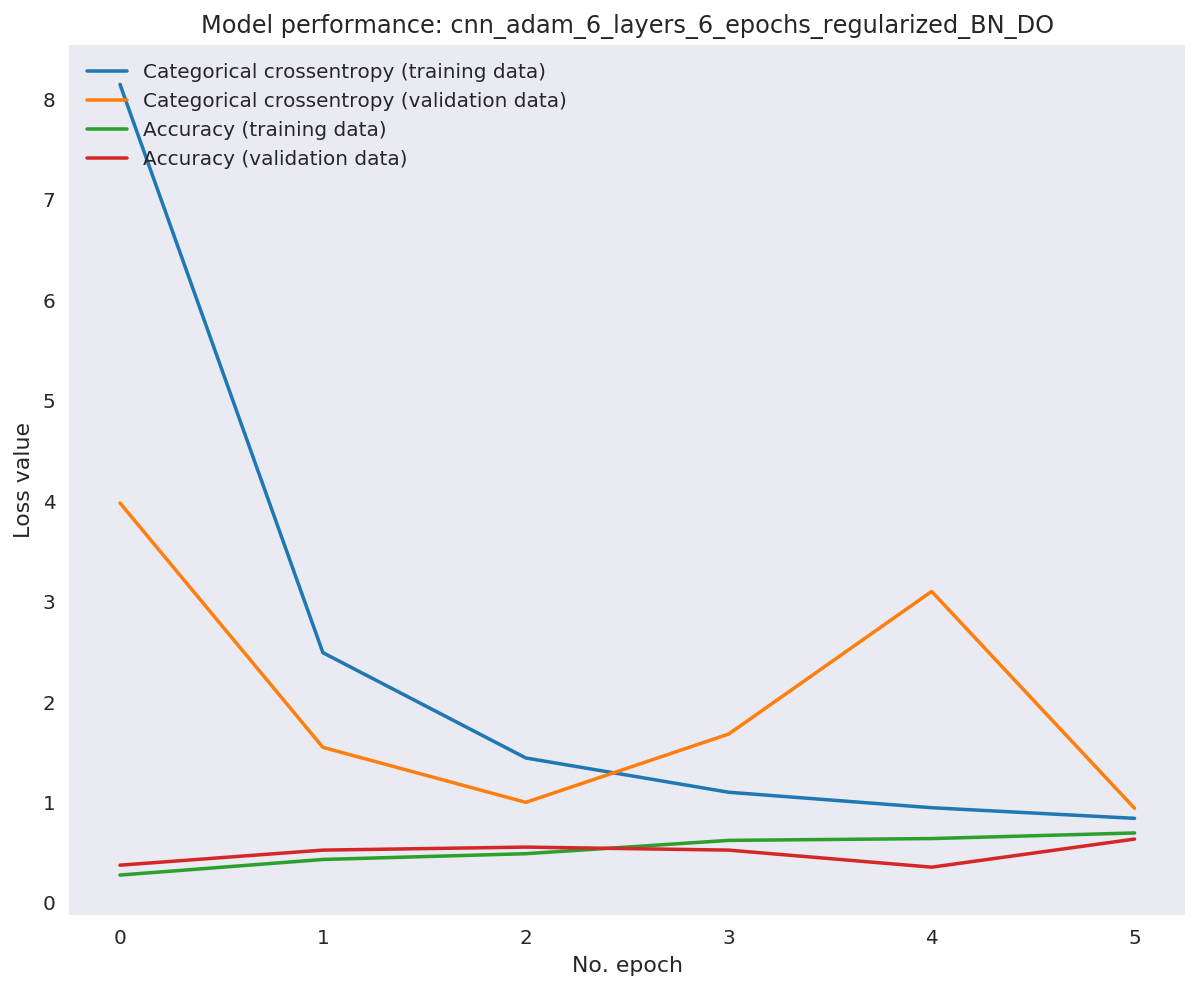

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,3.9767,0.3700,8.1454,0.2715,0.0010,0,cnn_adam_6_layers_6_epochs_regularized_BN_DO
1,1.5433,0.5200,2.4860,0.4268,0.0010,1,cnn_adam_6_layers_6_epochs_regularized_BN_DO
2,0.9958,0.5500,1.4375,0.4842,0.0010,2,cnn_adam_6_layers_6_epochs_regularized_BN_DO
3,1.6760,0.5200,1.0961,0.6169,0.0010,3,cnn_adam_6_layers_6_epochs_regularized_BN_DO
4,3.0960,0.3500,0.9421,0.6350,0.0010,4,cnn_adam_6_layers_6_epochs_regularized_BN_DO
5,0.9362,0.6300,0.8364,0.6908,0.0004,5,cnn_adam_6_layers_6_epochs_regularized_BN_DO


In [52]:
df = run_model(model, model_param)
collect_stats(df)

In [53]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, None, .25, .25,.25,None],
    "dense_input": [256,128],
    "image_shape": (120, 120),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, None, 0.25, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_20 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 15, 60, 60, 8)   

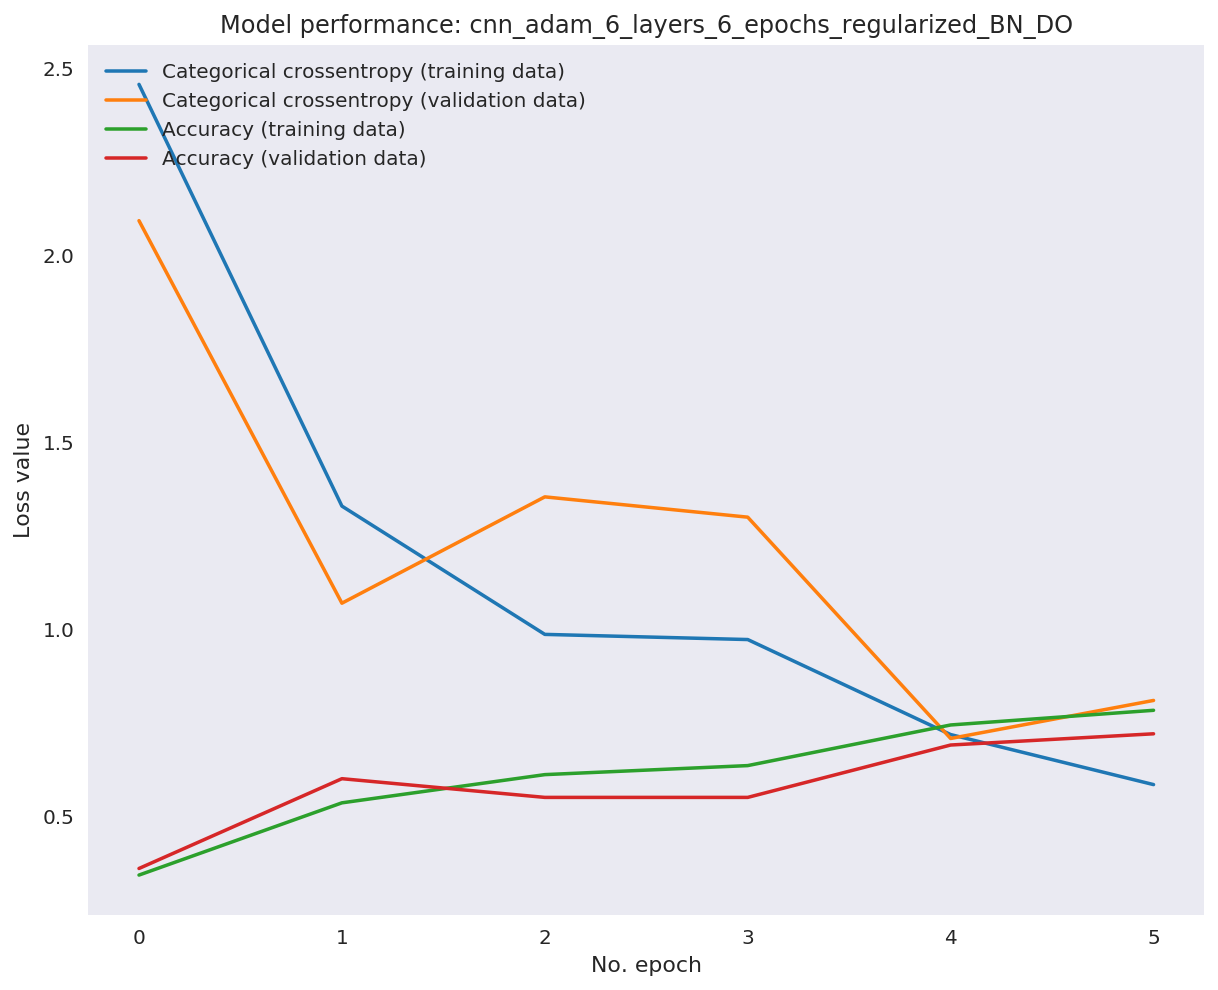

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,2.0916,0.3600,2.4559,0.3424,0.0010,0,cnn_adam_6_layers_6_epochs_regularized_BN_DO
1,1.0691,0.6000,1.3287,0.5354,0.0010,1,cnn_adam_6_layers_6_epochs_regularized_BN_DO
2,1.3533,0.5500,0.9857,0.6109,0.0010,2,cnn_adam_6_layers_6_epochs_regularized_BN_DO
3,1.2991,0.5500,0.9719,0.6350,0.0010,3,cnn_adam_6_layers_6_epochs_regularized_BN_DO
4,0.7075,0.6900,0.7179,0.7436,0.0004,4,cnn_adam_6_layers_6_epochs_regularized_BN_DO
5,0.8092,0.7200,0.5842,0.7828,0.0004,5,cnn_adam_6_layers_6_epochs_regularized_BN_DO


In [54]:
df = run_model(model, model_param)
collect_stats(df)

In [55]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 6,
    "filters": [8, 16, 32,64],
    "batch_normalize": True,
    "dropouts": [None, None, .25, .25,.25,None],
    "dense_input": [256,128],
    "image_shape": (100, 100),
    "decay_learning_rate":True
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)

In [ ]:
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, None, 0.25, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (100, 100)
decay_learning_rate -> True
kernel_shape_side -> 3
name -> cnn_adam_6_layers_6_epochs_regularized_BN_DO
input_shape -> (30, 100, 100, 3)
ADAM optimizer with learning rate:  0.001 True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 30, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 100, 100, 8)   32        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 15, 50, 50, 8)   

Model Params: 
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
num_epochs -> 20
batch_normalize -> True
filters -> [8, 16, 32, 64]
dropouts -> [None, None, 0.25, 0.25, 0.25, None]
dense_input -> [256, 128]
image_shape -> (120, 120)
decay_learning_rate -> True
kernel_shape_side -> 3
augmentors -> [<function rotate at 0x7fe3d2ad2b00>, <function blur at 0x7fe3d2ad28c0>, <function noise at 0x7fe3d2ad2680>, <function scale at 0x7fe383a48680>, <function flip at 0x7fe33032b3b0>]
name -> cnn_adam_6_layers_20_epochs_regularized_BN_DO
input_shape -> (24, 120, 120, 3)
ADAM optimizer with learning rate:  0.001 True
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_38 (Conv3D)           (None, 24, 120, 120, 8)   656       
____________________________________________________

67/67 [==============================] - 1394s 21s/step - loss: 0.0788 - categorical_accuracy: 0.9746 - val_loss: 1.4323 - val_categorical_accuracy: 0.7700

Epoch 00016: saving model to model_init_2020-09-1101_11_20.871439/model-00016-0.07958-0.97461-1.43230-0.77000.h5

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.
Epoch 17/20
67/67 [==============================] - 1379s 21s/step - loss: 0.0830 - categorical_accuracy: 0.9749 - val_loss: 0.7866 - val_categorical_accuracy: 0.7800

Epoch 00017: saving model to model_init_2020-09-1101_11_20.871439/model-00017-0.08310-0.97486-0.78662-0.78000.h5
Epoch 18/20
67/67 [==============================] - 1388s 21s/step - loss: 0.0835 - categorical_accuracy: 0.9708 - val_loss: 1.7971 - val_categorical_accuracy: 0.7700

Epoch 00018: saving model to model_init_2020-09-1101_11_20.871439/model-00018-0.08416-0.97084-1.79709-0.77000.h5

Epoch 00018: ReduceLROnPlateau reducing learning rate to 4.09600033890456e-06.
Epoc

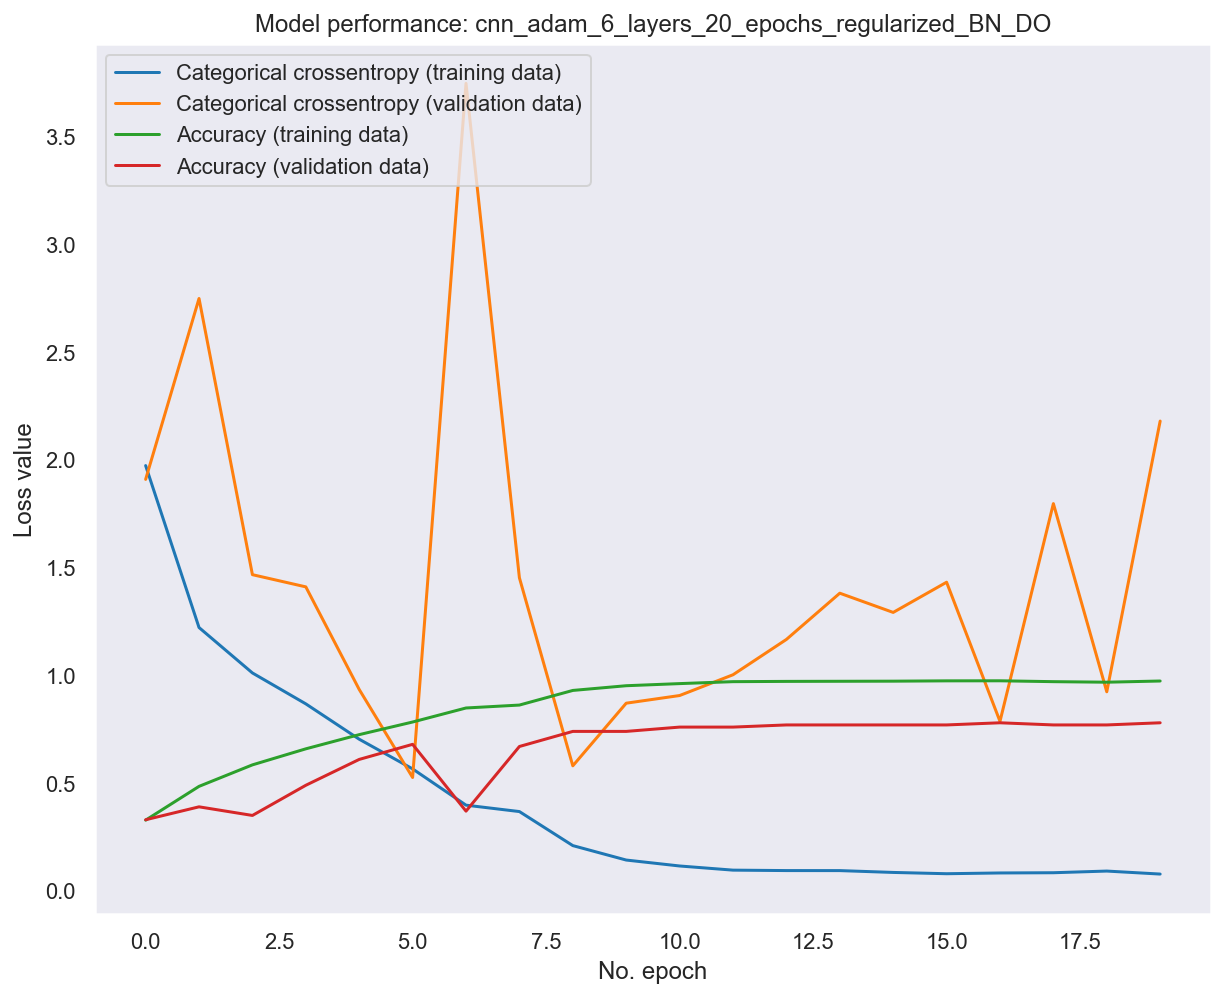

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.9094,0.3300,1.9737,0.3281,0.0010,0,cnn_adam_6_layers_20_epochs_regularized_BN_DO
1,2.7489,0.3900,1.2220,0.4849,0.0010,1,cnn_adam_6_layers_20_epochs_regularized_BN_DO
2,1.4674,0.3500,1.0113,0.5847,0.0010,2,cnn_adam_6_layers_20_epochs_regularized_BN_DO
3,1.4107,0.4900,0.8678,0.6591,0.0010,3,cnn_adam_6_layers_20_epochs_regularized_BN_DO
4,0.9346,0.6100,0.7037,0.7250,0.0010,4,cnn_adam_6_layers_20_epochs_regularized_BN_DO
5,0.5262,0.6800,0.5661,0.7836,0.0010,5,cnn_adam_6_layers_20_epochs_regularized_BN_DO
6,3.7472,0.3700,0.3977,0.8487,0.0010,6,cnn_adam_6_layers_20_epochs_regularized_BN_DO
7,1.4528,0.6700,0.3680,0.8622,0.0010,7,cnn_adam_6_layers_20_epochs_regularized_BN_DO
8,0.5803,0.7400,0.2101,0.9301,0.0004,8,cnn_adam_6_layers_20_epochs_regularized_BN_DO
9,0.8709,0.7400,0.1430,0.9520,0.0004,9,cnn_adam_6_layers_20_epochs_regularized_BN_DO


In [353]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (4, 28),
    "model_name": "cnn",
    "num_epochs": 20,
    "filters": [8, 16, 32, 64],
    "batch_normalize": True,
    "dropouts": [None, None, .25, .25, .25, None],
    "dense_input": [256, 128],
    "image_shape": (120, 120),
    "decay_learning_rate": True,
    "augmentors": image_augmentors
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Reference: 
- https://machinelearningmastery.com/cnn-long-short-term-memory-networks/
- https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00
- https://github.com/keras-team/keras/issues/3945

In [260]:
def create_cnn_rnn_model(model_param):
    assert model_param.is_rnn, "The params should be for RNN"
    model = Sequential()
    for index, f in enumerate(model_param.filters):
        if index == 0:
            model.add(
                TimeDistributed(Conv2D(f,
                                       kernel_size=(3, 3),
                                       activation='relu',
                                       strides=(2, 2),
                                       kernel_initializer='he_uniform',
                                       padding='same'),
                                input_shape=model_param.input_shape))
        else:
            model.add(
                TimeDistributed(
                    Conv2D(f,
                           kernel_size=(3, 3),
                           activation='relu',
                           strides=(2, 2),
                           kernel_initializer='he_uniform',
                           padding='same')))
        model.add(
            TimeDistributed(
                Conv2D(f,
                       kernel_size=(3, 3),
                       activation='relu',
                       strides=(2, 2),
                       kernel_initializer='he_uniform',
                       padding='same')))
        if model_param.batch_normalize:
            model.add(BatchNormalization())

        model.add(
            TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        if model_param.dropouts[index]:
            model.add(Dropout(model_param.dropouts[index]))

    model.add(TimeDistributed(Flatten()))
    for index, d in enumerate(model_param.rnn_layers):
        if model_param.rnn_layer_type == 'LSTM':
            model.add(LSTM(d, return_sequences=True))
        else:
            model.add(GRU(d, return_sequences=True))

        dropout_index = len(model_param.filters) + index
        if model_param.batch_normalize and dropout_index < len(
                model_param.dense_input):
            model.add(BatchNormalization())
        if model_param.dropouts[dropout_index]:
            model.add(Dropout(model_param.dropouts[dropout_index]))
    
    model.add(Flatten())
    
    for index, d in enumerate(model_param.dense_input):
        model.add(Dense(d, activation='relu', kernel_initializer='he_uniform'))
        dropout_index = len(model_param.filters) + len(
            model_param.rnn_layers) + index
        if model_param.batch_normalize and dropout_index < len(
                model_param.dense_input):
            model.add(BatchNormalization())
        if model_param.dropouts[dropout_index]:
            model.add(Dropout(model_param.dropouts[dropout_index]))

    model.add(Dense(5, activation='softmax'))
    return model

In [261]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn_rnn",
    "num_epochs": 6,
    "filters": [16, 16, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None, None],
    "dense_input": [128],
    "image_shape": (120, 120),
    "rnn_layers": [512],
    "rnn_layer_type": "LSTM"
}
model_param = ModelParam(params)
model = create_cnn_rnn_model(model_param)

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [16, 16, 32]
dropouts -> [None, None, None, None, None]
dense_input -> [128]
image_shape -> (120, 120)
rnn_layer_type -> LSTM
rnn_layers -> [256]
name -> cnn_rnn_sgd_4_layers_6_epochs_not_regularized
is_rnn -> True
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_112 (TimeDi (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_113 (TimeDi (None, 30, 30, 30, 16)    2320      
_________________________________________________________________
time_distributed_114 (TimeDi (None, 30, 15, 15, 16)    0         
_

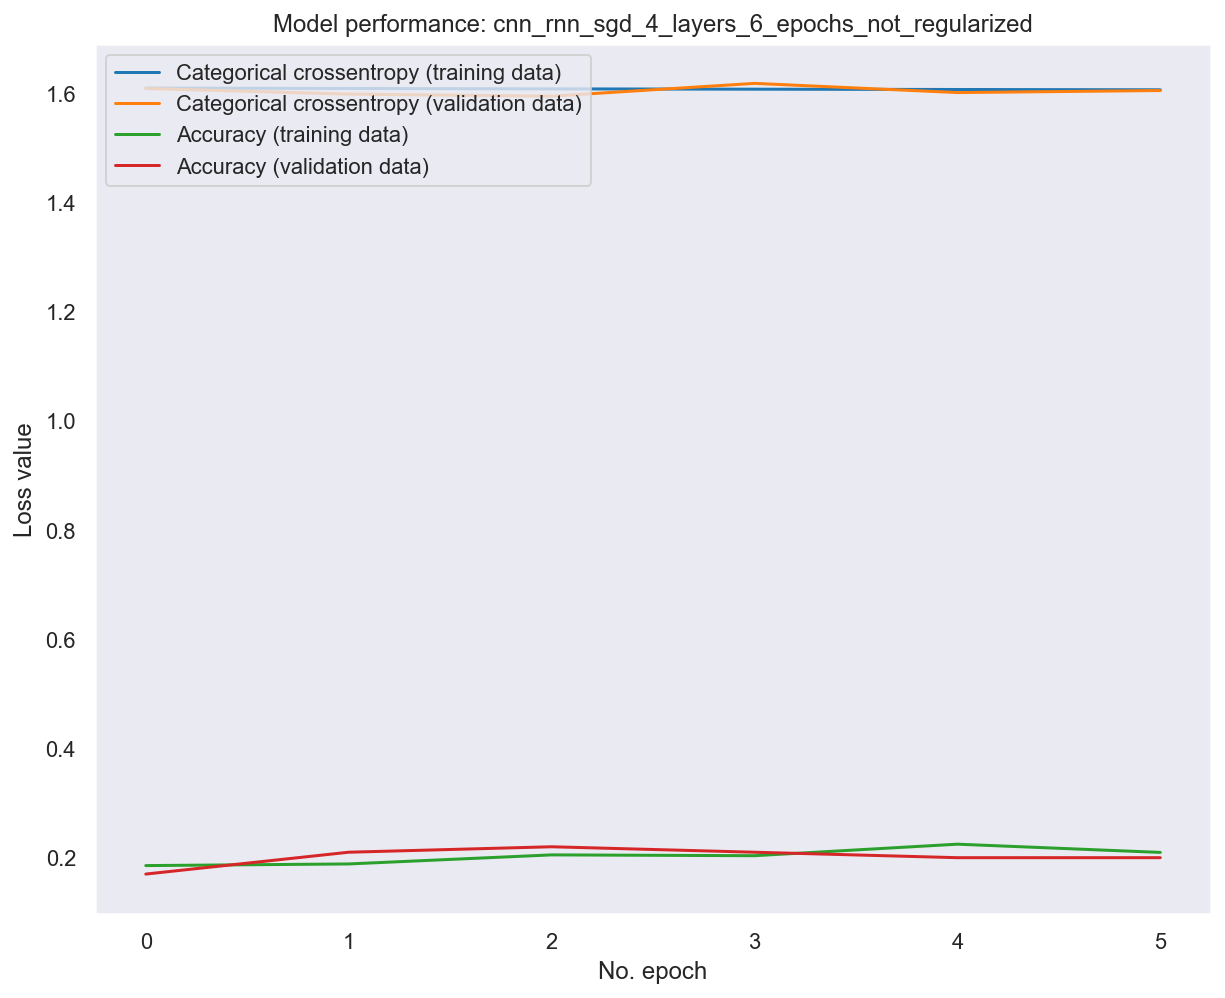

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.6087,0.1700,1.6094,0.1855,0.0010,0,cnn_rnn_sgd_4_layers_6_epochs_not_regularized
1,1.5984,0.2100,1.6087,0.1885,0.0010,1,cnn_rnn_sgd_4_layers_6_epochs_not_regularized
2,1.5946,0.2200,1.6080,0.2051,0.0010,2,cnn_rnn_sgd_4_layers_6_epochs_not_regularized
3,1.6181,0.2100,1.6074,0.2036,0.0010,3,cnn_rnn_sgd_4_layers_6_epochs_not_regularized
4,1.6012,0.2000,1.6069,0.2247,0.0010,4,cnn_rnn_sgd_4_layers_6_epochs_not_regularized
5,1.6050,0.2000,1.6063,0.2097,0.0004,5,cnn_rnn_sgd_4_layers_6_epochs_not_regularized


In [262]:
df = run_model(model, model_param)
collect_stats(df)

In [265]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn_rnn",
    "num_epochs": 6,
    "filters": [16, 32, 32],
    "batch_normalize": False,
    "dropouts": [None, None, None, None, None],
    "dense_input": [64],
    "image_shape": (120, 120),
    "rnn_layers": [256],
    "rnn_layer_type": "LSTM"
}
model_param = ModelParam(params)
model = create_cnn_rnn_model(model_param)

In [266]:
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 6
filters -> [16, 32, 32]
dropouts -> [None, None, None, None, None]
dense_input -> [64]
image_shape -> (120, 120)
rnn_layer_type -> LSTM
rnn_layers -> [256]
name -> cnn_rnn_sgd_4_layers_6_epochs_not_regularized
is_rnn -> True
input_shape -> (30, 120, 120, 3)
SGD optimizer with learning rate:  0.001
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_132 (TimeDi (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_133 (TimeDi (None, 30, 30, 30, 16)    2320      
_________________________________________________________________
time_distributed_134 (TimeDi (None, 30, 15, 15, 16)    0         
__

KeyboardInterrupt: 